# Simple Continuous Planning Domain Generator and Fast Simulator
This is a 2D nevigation domain generator, which are based on simple simulator rather than domain language(RDDL perhaps the only domain language can describe this simple domain). 

## Components
This code has 3 components.

1. 2D Nevigation Domain Generator
2. 2D Resampling Based Explorer
3. Deep Network Domain Transition Simulator(For fast simulation, when domain not availiable for planner)
4. Network Performance Visualized Evaluator
5. Keras Network Weights Extractor and File Writer for external Planners

## Contacts
1. [GA WU](mailto:wuga214@gmail.com)

## Preparation

### 1. Package installation

In [1]:
!pip --quiet install keras
!pip --quiet install h5py
!pip --quiet install shapely
!pip --quiet install descartes
!pip --quiet install tqdm
!pip --quiet install tensorflow

### 2. Package imports

In [3]:
%matplotlib inline
import random
import os
import json
import sys
import string
import unicodedata
from tqdm import tqdm
import pandas as pd
#Numpy and Scipy
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from scipy.spatial import distance
#KERAS
from keras.layers import Dense, Activation,Dropout
from keras.models import Sequential
from keras.regularizers import l1,l2
from keras.models import load_model

Using TensorFlow backend.


### 3. Supporting Functions

In [17]:
#Given local path, find full path
def PathFinder(path):
    script_dir = os.path.dirname('__file__')
    fullpath = os.path.join(script_dir,path)
    return fullpath

#Read Data for Deep Learning
def ReadData(path):
    fullpath=PathFinder(path)
    return pd.read_csv(fullpath, sep=',', header=0)

## Data Generation Part
### 1. Maze problem domain simulator

Brief Discription of this domain simulator

1. Define a 2D maze, which allows agent move continously in this domain. 
2. Has one Goal state and one start state. 
3. Allows to define obstacles that agent cannot move in, or it will transfered to jail.
4. There is a jail location that outside maze domain.
5. Agent alive in deadend in the period of tolerate time steps


In [5]:
'''
Created on Oct 20, 2016

This class has two construction functions.
1. From data
2. From initial settings

Example of 2D maze setting

initial_setting = {
    "maze"        : (0,0,10,10),                    #Continous state bound
    "start_state"     : (0,0),                          #Current State in X,Y and If in Jail
    "action_range"      : (-0.5,0.5),                     #The effective action range
    "goal_states"        : [(10,10)],                      #The goal state to finish running
    "jail_location"     : (-1,-1),                        #Jail location
    "obstacles"   : [[(1,1),(1,3),(3,3),(3,1)]],    #Some obstacles that never crosspassing
    "muds"     : [[(0,5),(5,5),(5,10),(0,10)]],  #Mud area where movement is halfed
    "deadend_toleration": 2                               #How many step left after getting into jail
                   }
@author: wuga
'''

#SHAPELY
from shapely.geometry import Point
from shapely.geometry import MultiPoint
from shapely.geometry import LineString
from shapely.geometry import Polygon
from shapely.geometry import box
from shapely.geometry.polygon import LinearRing
from descartes.patch import PolygonPatch

COLOR = {
    True:  '#6699cc',
    False: '#ff3333'
    }

class DeterministicMazeRemaster(object):
    
    def __init__(self, setting):
        maze=setting.get('maze')
        self.maze=box(maze[0],maze[1],maze[2],maze[3])
        obstacles=setting.get('obstacles')
        self.obstacles=[]
        if obstacles:
            for coord in obstacles:
                self.obstacles.append(Polygon(coord))
        
        muds=setting.get('muds')
        self.muds=[]
        if muds:
            for coord in muds:
                self.muds.append(Polygon(coord))
        start_state=setting.get('start_state')
        self.start_state=Point(start_state)
        self.current_state=self.start_state
        goal_states=setting.get('goal_states')
        self.goal_states=[]
        for coord in goal_states:
            self.goal_states.append(Point(coord))
        self.action_range=setting.get('action_range')
        self.deadend_toleration=setting.get('deadend_toleration')
        self.injail=False
        self.inmud=False
        self.backup = {k:v for k, v in self.__dict__.items() if not (k.startswith('__') and k.endswith('__'))}
        
    def PlotMaze(self):
        fig = plt.figure(dpi=90)
        ax = fig.add_subplot(111)
        x, y = self.maze.exterior.xy
        ax.plot(x, y, 'o', color='#999999', zorder=1)
        patch = PolygonPatch(self.maze, facecolor='#6699cc', edgecolor='#6699cc', alpha=0.5, zorder=2)
        ax.add_patch(patch)
        if self.muds:
            for mud in self.muds:
                patch = PolygonPatch(mud, facecolor='#ff3333', edgecolor='#ff3333', alpha=0.5,hatch='\\', zorder=2)
                ax.add_patch(patch)
        if self.obstacles:
            for obstacles in self.obstacles:
                patch = PolygonPatch(obstacles, facecolor='#ffaabb', edgecolor='#ffaabb', alpha=0.5,hatch='\\', zorder=2)
                ax.add_patch(patch)
        plt.show()
        
    def Reset(self):
        backup=self.backup
        self.__dict__.update(backup)
        self.backup = backup
    
    def UpdateState(self,new_state):
        self.current_state = new_state
        
    def InJail(self):
        if self.injail == True:
            return 1
        else:
            return -1
    
    def InMud(self):
        for mud in self.muds:
            if mud.intersects(self.current_state):
                self.Inmud=True
                return 1
            else:
                self.Inmud=False
        return -1
    
    def GetCurrentState(self):
        return self.current_state.x, self.current_state.y, self.InJail(),self.InMud()
        
    def TakeAction(self,action):
        if not self.injail:
            proposal=Point((self.current_state.x+action[0],self.current_state.y+action[1]))
            #print proposal.x, proposal.y
            path=LineString([self.current_state, proposal])
            
            if self.obstacles:
                for obstacle in self.obstacles:
                    if obstacle.intersects(path):
                        self.injail=True
                        self.current_state=Point((-1,-1))
                        return
            if self.muds:
                for mud in self.muds:
                    if mud.intersects(path):
#                         print 'we are here'
                        path_inmud = mud.intersection(path)
                        coords = [path.coords[0],path.coords[1]]
                        for loc in path_inmud.coords:
                            if loc not in coords:
                                coords.append(loc)
                        coords.sort(key=lambda tup: tup[1]) 
                        p_in_mud=proposal.intersects(mud)
                        s_in_mud=self.current_state.intersects(mud)
                        if p_in_mud and not s_in_mud: 
#                             print 'current not in mud'
                            if coords.index((self.current_state.x,self.current_state.y))==0: 
                                x = coords[1][0]-coords[0][0]+0.5*(coords[-1][0]-coords[1][0])
                                y = coords[1][1]-coords[0][1]+0.5*(coords[-1][1]-coords[1][1])
                                proposal=Point((coords[0][0]+x,coords[0][1]+y))
                            else:
                                x = coords[1][0]-coords[-1][0]+0.5*(coords[0][0]-coords[1][0])
                                y = coords[1][1]-coords[-1][1]+0.5*(coords[0][1]-coords[1][1])
                                proposal=Point((coords[-1][0]+x,coords[-1][1]+y))
                        elif s_in_mud and not p_in_mud:
#                             print 'proposal not in mud'
                            if coords.index((self.current_state.x,self.current_state.y))==0: 
                                x = 0.5*(coords[1][0]-coords[0][0])+(coords[-1][0]-coords[1][0])
                                y = 0.5*(coords[1][1]-coords[0][1])+(coords[-1][1]-coords[1][1])
                                proposal=Point((coords[0][0]+x,coords[0][1]+y))
                            else:
                                x = 0.5*(coords[1][0]-coords[-1][0])+(coords[0][0]-coords[1][0])
                                y = 0.5*(coords[1][1]-coords[-1][1])+(coords[0][1]-coords[1][1])
                                proposal=Point((coords[-1][0]+x,coords[-1][1]+y))
                        else:
                            proposal=Point((self.current_state.x+action[0]*0.5,self.current_state.y+action[1]*0.5))
            
            path=LineString([self.current_state, proposal])
            bounds=LinearRing(self.maze.exterior.coords) 
            if bounds.intersects(path):
                onedge=bounds.intersection(path)
                if  type(onedge) is MultiPoint:
                    for point in onedge:
                        if not point.equals(self.current_state):
                            proposal=point
                elif type(onedge) is Point:
                    if not onedge.equals(self.current_state):
                        proposal=onedge
                    elif not self.maze.contains(proposal):
                        proposal=bounds.interpolate(bounds.project(proposal))
                        
            self.current_state=proposal
        else:
            self.deadend_toleration=self.deadend_toleration-1
        return self.GetCurrentState()
        
    def IfGameEnd(self):
        for goal in self.goal_states:
            if self.current_state.equals(goal):
                self.Reset()
        if (self.deadend_toleration == 0):
            self.Reset()
    
    def DeltaDistance(self,new_state,old_state):
        delta=[]
        delta.append(new_state[0]-old_state[0])
        delta.append(new_state[1]-old_state[1])
        if (new_state[2]==1):
            delta.append(1)
        else:
            delta.append(-1)
        if (new_state[3]==1):
            delta.append(1)
        else:
            delta.append(-1)
        return delta


#### Simulator Test code

This is an example of defining a maze, and corresponding functionality testing code. Note the initial setting is an example of specification for instantiate a map.

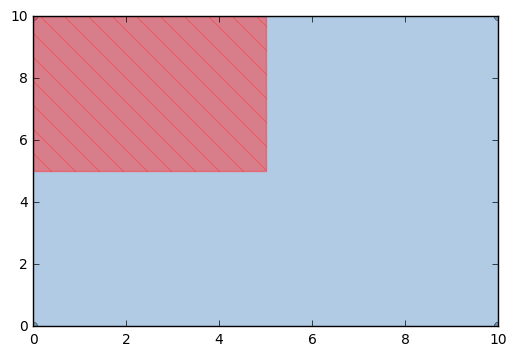

(0.0, 0.0, -1, -1)
(2.0, 10.0, -1, 1)
2
(1.0, 9.0, -1, 1)
2
(2.0, 10.0, -1, 1)
2


In [6]:
initial_setting = {
    "maze"              : (0,0,10,10),                    #Continous state bound
    "start_state"       : (0,0),                          #Current State in X,Y and If in Jail
    "action_range"      : (-0.5,0.5),                     #The effective action range
    "goal_states"       : [(10,10)],                      #The goal state to finish running
    "jail_location"     : (-1,-1),                        #Jail location
    "obstacles"         : [], #[[(5,2),(5,5),(8,5),(8,2)]], Some obstacles that never crosspassing
    "muds"              : [[(0,5),(0,10),(5,10),(5,5)]],  #Mud area where movement is halfed
    "deadend_toleration": 2                               #How many step left after getting into jail
}

Maze=DeterministicMazeRemaster(initial_setting)
Maze.backup
Maze.PlotMaze()
print Maze.GetCurrentState()
Maze.TakeAction([5,25])
print Maze.GetCurrentState()
print Maze.deadend_toleration
Maze.TakeAction([-2,-2])
print Maze.GetCurrentState()
print Maze.deadend_toleration
Maze.TakeAction([2,2])
print Maze.GetCurrentState()
print Maze.deadend_toleration

### 2. Random Explorer
This is a random walker, who will explore the maze randomly. This is just for generate more random data to support transition function training. 

In [7]:
class RandomWalk(object):
    def __init__(self, ranges):
        self.ranges=ranges
    
    def Go(self,epsilon):
        stride=[]
        for i in range(2):
            if random.uniform(0,1)<epsilon:
                stride.append(random.triangular(self.ranges[0],self.ranges[1], 0.2))
            else:
                stride.append(random.uniform(self.ranges[0],self.ranges[1]))
        return stride
    
    def GoPlus(self, state):
        SampleSet=[]
        z=0
        for i in range(5):
            stride=[] 
            for j in range(2):
                stride.append(random.uniform(self.ranges[0],self.ranges[1]))#2-norm resampling
            value=np.linalg.norm([sum(x) for x in zip(stride, state[:2])])
            z=z+value
            SampleSet.append([stride[0],stride[1],value])
        SampleSet=np.array(SampleSet)
        for i in range(len(SampleSet)):
            SampleSet[i,2]=SampleSet[i,2]/z
        finalsample=np.nonzero(np.random.multinomial(1, SampleSet[:,2], size=1)==1)[1][0]
        return [SampleSet[finalsample,0],SampleSet[finalsample,1]]

In [8]:
Maze=DeterministicMazeRemaster(initial_setting)
Planner=RandomWalk(Maze.action_range)
for i in range(10):
    Planner.Go(0.3)

In [9]:
state=(5,5,0,0)
for i in range(10):
    Planner.GoPlus(state)

### 3. Sampled Data writter
This class combine the simulator and planner to generate some routing data from multiple tries. 

In [10]:
class DataGenerator(object):
    def __init__(self, model):
            self.maze=model
            self.planner=RandomWalk(self.maze.action_range)
            
    def WriteData(self,size,datapath,labelpath,epsilon):
        fulldatapath=PathFinder(datapath)
        fulllabelpath=PathFinder(labelpath)
        datafile = open(fulldatapath,'w')
        datafile.write('State:axis[$x],State:axis[$y],State:injail,State:inmud,Action:move[$x],Action:move[$y]\n')
        labelfile = open(fulllabelpath,'w')
        labelfile.write('State:delta[$x],State:delta[$y],State:injail,State:inmud\n')
        for i in tqdm(range(0,size)):
            self.maze.IfGameEnd()
            old_state=self.maze.GetCurrentState()
            action=self.planner.GoPlus(old_state)
            self.maze.TakeAction(action)
            new_state=self.maze.GetCurrentState()
            Data=list(old_state)+action
            Label=self.maze.DeltaDistance(new_state,old_state)
            datafile.write(','.join(map(str, Data))+'\n')
            labelfile.write(','.join(map(str, Label))+'\n')
        datafile.close()
        labelfile.close()

#### Call above classes!

In [11]:
Maze=DeterministicMazeRemaster(initial_setting)
Generator=DataGenerator(Maze)
Datapath="StateActionData.txt"
Labelpath="StateActionLabel.txt"
Generator.WriteData(100000,Datapath,Labelpath,0.3)

100%|██████████| 100000/100000 [00:55<00:00, 1804.30it/s]


## Transition Function Learning Part

### 1. Data Normalize Function
Note that the normalization of input variable is critical to get better prediction result for deep net. This is one of the tricks that increase the performance.

In [12]:
def Normalize(features, mean = [], std = []):
    if mean == []:
        mean = np.mean(features, axis = 0)
        std = np.std(features, axis = 0)
#     print std
#     print std[:,None]
    new_feature = (features.T - mean[:,None]).T
    new_feature = (new_feature.T / std[:,None]).T
    new_feature[np.isnan(new_feature)]=0
#     print new_feature
    return new_feature, mean, std

### 2. Deep Net Structure
The network is a framework that support modifying deeps and number of nodes for each layer. you need to specify those through parameters that instantiate the following class. The network is using Dropout technique to avoid overfitting. Another option is L2 regularization for each layer. However, we cannot use both in the network.

In [13]:
import tensorflow as tf
tf.python.control_flow_ops = tf
class FullyConnectedDeepNet(object):
    '''

    '''
    def __init__(self,observ,hidden,output,num_layers,drop_out):
        self.drop_out=drop_out
        self.DeepNet = Sequential()
        #self.Autoencoder.add(Dropout(0.5, input_shape=(observ,)))
        self.DeepNet.add(Sequential([Dense(hidden, input_dim=observ), Activation('relu')]))
        self.DeepNet.add(Dropout(drop_out))
        if num_layers > 1:
            for i in range(num_layers-1):
                self.DeepNet.add(Sequential([Dense(hidden, input_dim=hidden), Activation('relu')]))
                self.DeepNet.add(Dropout(drop_out))
        self.DeepNet.add(Dense(output, input_dim=hidden))
        self.DeepNet.compile(optimizer='rmsprop', loss='mse')
    
    def Train(self,data,label,epoch, normalize=False):
        mean=[]
        std=[]
        if normalize:
            normalized_data,mean,std=Normalize(data)
        else:
            normalized_data=data
        self.DeepNet.fit(normalized_data, label, nb_epoch=epoch)
        return mean,std

    def Test(self,datapoint,normalize=False,mean=[],std=[]):
        if normalize:
            normalized_datapoint,_,_=Normalize(datapoint,mean,std)
        else:
            normalized_datapoint=datapoint
        return self.DeepNet.predict(normalized_datapoint, batch_size=128, verbose=0)
    
    def LoadModel(self,modelpath):
        self.DeepNet=load_model(modelpath)
    
    def Save(self,modelpath):
        self.DeepNet.save(modelpath)
        
    def GetModel(self):
        return self.DeepNet

### 2. Training
#### Preparing Data for both training and testing.
Since the simulator generate both injail and inmud information, we only choose one for later experiments. Thus the data preparing procedure is a little massy.

In [18]:
Datapath="StateActionData.txt"
Labelpath="StateActionLabel.txt"
DNN_DELTA=FullyConnectedDeepNet(5,32,2,4,0.1)
DNN_INMUD=FullyConnectedDeepNet(5,32,1,1,0.1)
PD_Data = ReadData(Datapath)
PD_Label = ReadData(Labelpath)
Full_Data=PD_Data.as_matrix()
Full_Label=PD_Label.as_matrix()
indecs=np.random.permutation(len(Full_Data))
Full_Data=Full_Data[indecs]
Full_Data=Full_Data[:,[0,1,3,4,5]]
Full_Label=Full_Label[indecs]
Full_Label=Full_Label[:,[0,1,3]]
Full_Size=len(Full_Data)
Train_Data = Full_Data[:int(Full_Size*0.9)]
Train_Label = Full_Label[:int(Full_Size*0.9)]
Test_Data = Full_Data[int(Full_Size*0.9):]
Test_Label = Full_Label[int(Full_Size*0.9):]
print 'Preprocessing finished'

Preprocessing finished


#### Train Models and Return Normalization info for testing

In [19]:
print Train_Data.shape,Train_Label[:,2][...,None].shape
#DNN_DELTA.Train(np.append(Train_Data, Train_Label[:,2][...,None], 1),Train_Label[:,:2],10)
mean_DELTA,std_DELTA=DNN_DELTA.Train(Train_Data, Train_Label[:,:2], 10,True)
mean_INMUD,std_INMUD=DNN_INMUD.Train(Train_Data,Train_Label[:,2],5, True)

(90000, 5) (90000, 1)
Epoch 1/10
90000/90000 [==============================] - 3s - loss: 0.0067     
Epoch 2/10
90000/90000 [==============================] - 3s - loss: 0.0044     
Epoch 3/10
90000/90000 [==============================] - 2s - loss: 0.0041     
Epoch 4/10
90000/90000 [==============================] - 2s - loss: 0.0039     
Epoch 5/10
90000/90000 [==============================] - 2s - loss: 0.0037     
Epoch 6/10
90000/90000 [==============================] - 2s - loss: 0.0035     
Epoch 7/10
90000/90000 [==============================] - 2s - loss: 0.0034     
Epoch 8/10
90000/90000 [==============================] - 2s - loss: 0.0033     
Epoch 9/10
90000/90000 [==============================] - 2s - loss: 0.0032     
Epoch 10/10
90000/90000 [==============================] - 2s - loss: 0.0031     
Epoch 1/5
90000/90000 [==============================] - 2s - loss: 0.1058     
Epoch 2/5
90000/90000 [==============================] - 2s - loss: 0.0750     
Epoch 3

In [221]:
DNN_INMUD.Save("TransitionModel_INMUD.h5")

#### Simple window to see the performance of the network. More obvious evaluation is given in visualization section

In [20]:
# Show performance of the DNN model(Samples)
Test_Pred = np.concatenate((DNN_DELTA.Test(Test_Data,True,mean_DELTA,std_DELTA), DNN_INMUD.Test(Test_Data,True,mean_INMUD, std_INMUD)), axis=1)
print Test_Pred[:3]
print Test_Label[:3]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


[[-0.09318303 -0.01943638  0.99660265]
 [-0.12211585 -0.05914227  0.99399698]
 [ 0.00550678  0.334925   -1.0476042 ]]
[[-0.10393511 -0.02051251  1.        ]
 [-0.13999601 -0.06364635  1.        ]
 [-0.00253869  0.47409031 -1.        ]]


## Visualization

The visualization gives two information
1. The performance of classifying inmud or not-inmud in the 2D map
2. The performance of DNN transition function vs True transition function. 

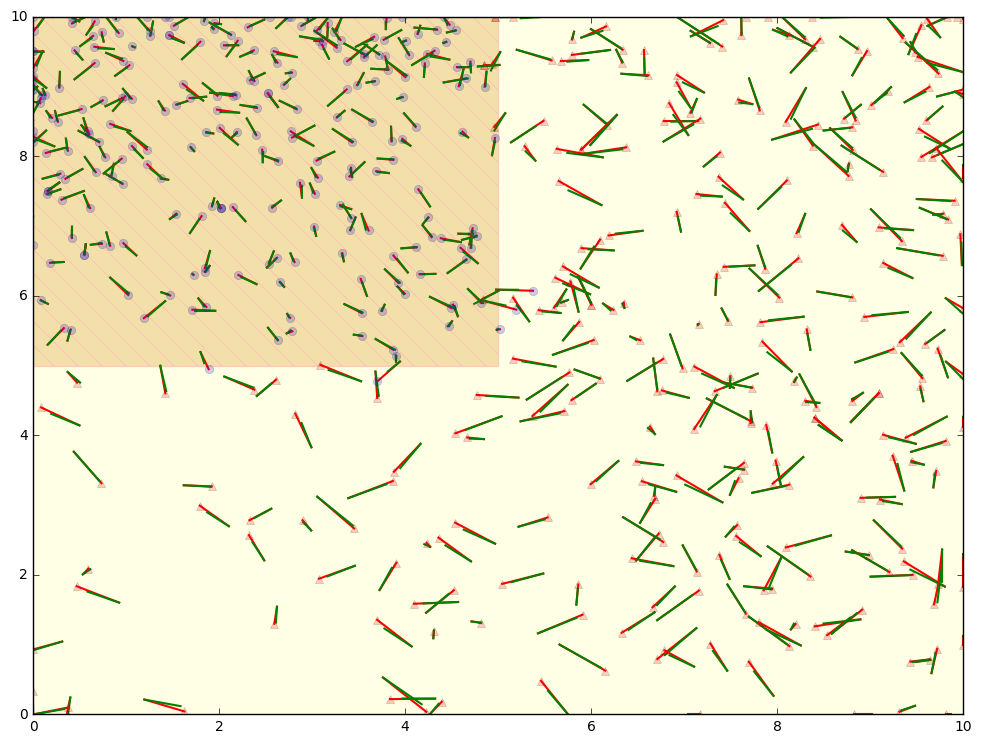

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl

def Virtualizing(Data, Label, Pred, Map,Obstacles,Muds,SampleSize):
    sample_index=np.random.choice(len(Data), SampleSize)
    #print sample_index
    #print Train_Data[sample_index,:2],Train_Label[sample_index,:2]
    fig9 = plt.figure(figsize=(12, 9), dpi=100)
    ax9 = fig9.add_subplot(111)
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    patch = PolygonPatch(Map, facecolor='#ffffcc', edgecolor='#ffffcc', alpha=0.5, zorder=2)
    ax9.add_patch(patch)
    MIN=min(Pred[:,2])
    MAX=max(Pred[:,2])
    for i in sample_index:
        plt.plot([Data[i,0],Data[i,0]+Label[i,0]], [Data[i,1],Data[i,1]+Label[i,1]], 'r-',lw=1.5)
        plt.plot([Data[i,0],Data[i,0]+Pred[i,0]], [Data[i,1],Data[i,1]+Pred[i,1]], 'g-',lw=1.5)
        
        #Test Classification Result
        if int(round(Pred[i,2]))==-1:
            plt.plot([Data[i,0]+Label[i,0]], [Data[i,1]+Label[i,1]],'r^',alpha=0.2,lw=1.5)
        else:
            plt.plot([Data[i,0]+Label[i,0]], [Data[i,1]+Label[i,1]], 'bo',alpha=0.2,lw=1.5)    
#        plt.scatter([Data[i,0]+Label[i,0]], [Data[i,1]+Label[i,1]],vmin=MIN, vmax=MAX,c=Pred[i],cmap=mpl.cm.get_cmap('hot'))
        #
        
    for obstacle in Obstacles:
        patch = PolygonPatch(obstacle, facecolor='#ffaabb', edgecolor='#ffaabb', alpha=0.2,hatch='\\', zorder=2)
        ax9.add_patch(patch)
    for mud in Muds:
        patch = PolygonPatch(mud, facecolor='#E8C06F', edgecolor='#ffaabb', alpha=0.5,hatch='\\', zorder=2)
        ax9.add_patch(patch)
    plt.show()

Virtualizing(Test_Data,Test_Label,Test_Pred,Maze.maze,Maze.obstacles,Maze.muds,500)

## Output(File stream for planner's)
### 1.Intermediate Output Extraction

The following functions is used to extract intermediate output of training dataset so that we can extract distribution of the output of each activation node. Although we assuming the distribution of activation is the normal, it is not the truth. This only gives a hint to make upper and lower bounds for the output easily. Note, the lower bound is always zero.

In [22]:
from theano.tensor.nnet import relu

def Interm_Distribution(layers,data):
    weights_bias=[]
    mean_matrix=[]
    std_matrix=[]
    for layer in layers: 
        if type(layer) is not Dropout:
            weights_bias.append(layer.get_weights())
    m,n=np.array(weights_bias).shape
    previous_LayerOutput=data
    for i in range(m):
        LayerOutput = relu(np.dot(previous_LayerOutput,weights_bias[i][0])+np.array(weights_bias[i][1]))
        previous_LayerOutput=LayerOutput
        mean_matrix.append(np.mean(LayerOutput, axis=0))
        std_matrix.append(np.std(LayerOutput, axis=0))
    return mean_matrix,std_matrix

def write_Interm_Ditribution(means,stds, filepath,hiddenstart='N'):
    fullpath=PathFinder(filepath)
    filehandler = open(fullpath,'w')
    for i in range(len(means)-1):
        row = []
        for j in range(len(means[i])):
            row.append(hiddenstart+str(i+1)+str(j))
            row.append(means[i][j])
            row.append(stds[i][j])
        filehandler.write(','.join(map(str, row))+'\n')
    filehandler.close()
    print 'Done!'
    
        
mean_Matrix,std_Matrix=Interm_Distribution(DNN_DELTA.GetModel().layers,Train_Data)
write_Interm_Ditribution(mean_Matrix,std_Matrix,'Interm_Distribution_DELTA.txt','D')
mean_Matrix,std_Matrix=Interm_Distribution(DNN_INMUD.GetModel().layers,Train_Data)
write_Interm_Ditribution(mean_Matrix,std_Matrix,'Interm_Distribution_INMUD.txt','I')
    

    

Done!
Done!


### 2. Network Dumping
The following class is used to extract weights from Keras model and dump it into text file that is easy to be loaded by planners.

In [23]:
class NetTopology(object):
    def __init__(self,layers,normalized=False,mean=[],std=[]):
        print mean
        self.layers=layers
        self.input_dim=layers[0].get_config()[0].get('config').get('input_dim')
        self.num_upper_layers=len(layers)
        self.mean=mean
        self.std=std
        self.nodenames=[]
        layernodename=[]
        for i in range(0, self.input_dim):
            layernodename.append('N0'+str(i))
        layernodename.append('B0')
        self.nodenames.append(layernodename)
        
    def LayerWiseTransform(self,layer,layer_id, lastlayer=False, hiddenstart='N', writefile=False, filehandler=None):
        if not lastlayer:
            input_dim = layer.get_config()[0].get('config').get('input_dim')
            output_dim = layer.get_config()[0].get('config').get('output_dim')
            activation = layer.get_config()[1].get('config').get('activation')
        else:
            input_dim = layer.get_config().get('input_dim')
            output_dim = layer.get_config().get('output_dim')
            activation = layer.get_config().get('activation')
        layernodename=[]
        weights_bias=layer.get_weights()
        weights=weights_bias[0]
        bias=weights_bias[1]
        for i in range(0, output_dim):
            layernodename.append(hiddenstart+str(layer_id)+str(i))
        for i in range(0, output_dim):
            row = [layernodename[i],activation]
            for j in range(0, input_dim):
                row.append(self.nodenames[-1][j])
                row.append(weights[j][i])
            row.append(self.nodenames[-1][-1])
            row.append(bias[i])
            if writefile:
                filehandler.write(','.join(map(str, row))+'\n')
            else:
                print ','.join(map(str, row))
        layernodename.append('B'+str(layer_id))
        self.nodenames.append(layernodename)
        
    def NetTransform(self,hiddenstart='N', writefile=False, filepath=None,overwrite=False):
        filehandler=None
        if writefile:
            fullpath=PathFinder(filepath)
            if overwrite is True:
                filehandler = open(fullpath,'w')
            else:
                filehandler = open(fullpath,'a')
        counter=0
        for i in range(0,self.num_upper_layers):
            if type(self.layers[i]) is not Dropout:
                if (i==self.num_upper_layers-1):
                    self.LayerWiseTransform(self.layers[i],counter+1, True, hiddenstart, writefile, filehandler)
                else:
                    self.LayerWiseTransform(self.layers[i],counter+1, False, hiddenstart, writefile, filehandler)
                counter=counter+1
        if writefile:
            if not overwrite:
                filehandler.write('\n')
                filehandler.write('MEAN:\n')
                filehandler.write(','.join(map(str, self.mean))+'\n')
                filehandler.write('STD:\n')
                filehandler.write(','.join(map(str, self.std))+'\n')
            filehandler.close()
        else:
            if not overwrite:
                print "MEAN:"
                print ','.join(map(str, self.mean))
                print "STD:"
                print ','.join(map(str, self.std))
        print 'Done!'
                    
Topo_DELTA=NetTopology(DNN_DELTA.GetModel().layers,True, mean_DELTA, std_DELTA)
Topo_DELTA.NetTransform('D',True, "Network_MIX.txt",True)
Topo_INMUD=NetTopology(DNN_INMUD.GetModel().layers,True, mean_INMUD, std_INMUD)
Topo_INMUD.NetTransform('I',True, "Network_MIX.txt",False)
        
    

[  4.94990427e+00   6.59306391e+00  -1.06711111e-01   5.35002642e-03
   9.29328127e-03]
Done!
[  4.94990427e+00   6.59306391e+00  -1.06711111e-01   5.35002642e-03
   9.29328127e-03]
Done!


# Data from RDDL Simulator

In [29]:
def inPutFiles(PD_Data,PD_Label,Input_Num,Output_Num,Hidden_Head, Net_Depth, Head_Path,Type):#Type in {Regular,Delta}
    Headers=list(PD_Data.columns.values)+list(PD_Label.columns.values)
    fullpath=PathFinder(Head_Path)
    filehandler = open(fullpath,'w')
    for i in range(Input_Num):
        filehandler.write('N0'+str(i)+':='+Headers[i]+'\n') 
    for i in range(Output_Num):
        filehandler.write(Hidden_Head+str(Net_Depth)+str(i)+':='+Type+': '+Headers[i+Input_Num]+'\n') 
    filehandler.close()

In [31]:
def trainNetForData(Datapath,Labelpath,Headpath):
    PD_Data = ReadData(Datapath)
    PD_Label = ReadData(Labelpath)
    Full_Data=PD_Data.as_matrix()
    Full_Label=PD_Label.as_matrix()
    indecs=np.random.permutation(len(Full_Data))
    Full_Data=Full_Data[indecs]
    Full_Label=Full_Label[indecs]
    m_data,n_data=Full_Data.shape
    m_label,n_label=Full_Label.shape
    inPutFiles(PD_Data,PD_Label,n_data,n_label,'D',4+1,Headpath,'Regular')#Could be Delta
    Train_Data = Full_Data[:int(m_data*0.9)]
    Train_Label = Full_Label[:int(m_data*0.9)]
    Test_Data = Full_Data[int(m_data*0.9):]
    Test_Label = Full_Label[int(m_data*0.9):]
    
    DNN=FullyConnectedDeepNet(n_data,32,n_label,4,0.1)
    mean_DNN,std_DNN=DNN.Train(Train_Data, Train_Label, 500,True)
    return DNN,mean_DNN,std_DNN,Train_Data
    
Datapath="Reservoir_Data.txt"
Labelpath="Reservoir_Label.txt"
Headpath="Headers_RDDL_Reservoir.txt"
#trainNetForData(Datapath,Labelpath,Headpath)
MODEL,MEAN,STD,Train_Data = trainNetForData(Datapath,Labelpath,Headpath)
Topo=NetTopology(MODEL.GetModel().layers,True, MEAN, STD)
Topo.NetTransform('D',True, "Network_RDD_Reservoir.txt",True)
mean_Matrix,std_Matrix=Interm_Distribution(MODEL.GetModel().layers,Train_Data)
write_Interm_Ditribution(mean_Matrix,std_Matrix,'Interm_Distribution_RDD_Reservoir.txt','D')
print 'Preprocessing finished'

Preprocessing finished


## Advices
1. Please run the code one by one top-down. Some function requires the previous results to support.
2. The installation list in the first line may not sufficient. Please install those software if you see an error.
3. Mac system user probably need a brew python rather than preinstalled python because the six-10 may not able to update under default setting.